# Notebook 11: RAG Evaluation with LLM-as-Judge

**Module 3: RAG Evaluation Techniques**

---

## 📚 Overview

This notebook demonstrates how to evaluate Retrieval-Augmented Generation (RAG) systems using **LLM-as-Judge** methodology. Instead of using automated metrics frameworks like Ragas, we leverage a powerful language model to act as an evaluator, providing detailed reasoning and scoring for RAG system outputs.

### What is LLM-as-Judge?

LLM-as-Judge is an evaluation approach where you use one LLM to evaluate the outputs of another LLM. The "judge" LLM assesses quality based on explicit criteria, providing both:
- **Quantitative scores**: Numerical ratings (0-3 scale)
- **Qualitative reasoning**: Detailed explanations for each score

This approach offers **flexibility** and **transparency** that complement traditional automated metrics.

---

## 🎯 Learning Objectives

By completing this notebook, you will:

- Understand the **LLM-as-Judge evaluation methodology**
- Learn when to use LLM-as-Judge vs automated frameworks like Ragas
- Implement a **complete RAG pipeline** (same as Notebook 10)
- Design **structured evaluation prompts** with Pydantic models
- Evaluate RAG systems across **3 core metrics**:
  - 🎯 **Groundedness**: Is the answer faithful to retrieved context?
  - 🎯 **Answer Relevance**: Does the answer address the question?
  - 🎯 **Retrieval Quality**: Are the retrieved contexts relevant?
- Analyze results with **detailed reasoning** and visualizations
- Understand **cost and performance trade-offs**

---

## 🔧 Prerequisites

- Completed Notebooks 01-07 (or equivalent RAG knowledge)
- Familiarity with LangChain LCEL syntax
- OpenAI API key
- Understanding of Pydantic for structured outputs

---

## 📖 Notebook Structure

1. **Introduction and Context** (🔰 BEGINNER)
2. **Environment Setup** (🔰 BEGINNER)
3. **RAG Pipeline Implementation** (🎓 INTERMEDIATE)
4. **Understanding LLM-as-Judge** (🎓 INTERMEDIATE)
5. **Judge Implementation** (🎓 INTERMEDIATE)
6. **Generate Evaluation Dataset** (🎓 INTERMEDIATE)
7. **Run Evaluations** (🚀 ADVANCED)
8. **Results Analysis** (🚀 ADVANCED)
9. **Cost and Performance Analysis** (🚀 ADVANCED)

---

## ⚖️ LLM-as-Judge vs Ragas Framework

| Aspect | LLM-as-Judge | Ragas Framework |
|--------|-------------|----------------|
| **Flexibility** | High - custom metrics and criteria | Medium - preset metrics |
| **Reasoning** | Excellent - detailed step-by-step explanations | Limited - scores only |
| **Consistency** | Good - with temperature=0 | Excellent - standardized metrics |
| **Setup** | Low - just prompts and Pydantic models | Medium - metric configuration |
| **Cost** | $0.08-0.12 per evaluation run | $0.05-0.08 per run |
| **Time** | 5-8 minutes per run | 7-12 minutes per run |
| **Best For** | Custom metrics, detailed feedback, subjective qualities | Standardized benchmarks, large-scale evaluation |

### When to Use Each?

**Use LLM-as-Judge when:**
- ✅ You need custom evaluation metrics
- ✅ You want detailed reasoning and explanations
- ✅ You're evaluating subjective qualities (tone, style, helpfulness)
- ✅ You have small to medium evaluation sets (<1000 questions)
- ✅ You want to understand *why* something scored a certain way

**Use Ragas Framework when:**
- ✅ You need industry-standard benchmarks
- ✅ You're running large-scale evaluations (1000+ questions)
- ✅ Cost is a primary constraint
- ✅ You want consistent, reproducible metrics
- ✅ You're comparing against published baselines

**Best Practice**: Use both approaches! LLM-as-Judge provides depth and insight, while Ragas provides standardization and efficiency.

---

Let's get started! 🚀

---

# Section 2: Environment Setup 🔰

## 2.1 Install Required Packages

We'll need the following packages:
- **langchain** family: Core RAG components
- **pydantic**: Structured outputs for judge responses
- **faiss-cpu**: Vector store
- **matplotlib, seaborn, pandas**: Data visualization
- **python-dotenv**: Environment variables

In [ ]:
# Install required packages (uncomment if needed)
# !pip install langchain==0.3.21 langchain-openai==0.3.0 langchain-community==0.3.20
# !pip install langchain-text-splitters==0.3.4 langchain-core==0.3.28
# !pip install pydantic==2.10.6 faiss-cpu==1.9.0
# !pip install matplotlib==3.10.0 seaborn==0.13.2 pandas==2.2.3
# !pip install python-dotenv==1.0.1

## 2.2 Import Libraries

In [3]:
# Standard library imports
import os
import warnings
from typing import List

# Data manipulation and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pydantic for structured outputs
from pydantic import BaseModel, Field
from enum import Enum

# LangChain imports
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter

from langchain_google_genai import GoogleGenerativeAIEmbeddings, ChatGoogleGenerativeAI

# Environment variables
from dotenv import load_dotenv

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


## 2.3 Load OpenAI API Key

Make sure you have your OpenAI API key in a `.env` file:
```
OPENAI_API_KEY=sk-proj-your-key-here
```

In [2]:
# Load environment variables
load_dotenv()

# Verify API key is set
if not os.getenv("GOOGLE_API_KEY"):
    raise ValueError("❌ GOOGLE_API_KEY not found in environment variables. Please set it in your .env file.")

print("✓ GOOGLE_API_KEY  key loaded successfully")

✓ GOOGLE_API_KEY  key loaded successfully


## 2.4 Initialize Models

We'll use:
- **text-embedding-3-small**: For document embeddings (1536 dimensions)
- **gpt-4o-mini**: For both RAG generation and judge evaluation

In [4]:
# Initialize OpenAI embeddings
embeddings = GoogleGenerativeAIEmbeddings(model="models/gemini-embedding-001")
print("✓ Embeddings model initialized")

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",       # Free-tier compatible
    temperature=0,             # Deterministic outputs
    max_tokens=2000,
)

judge_llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",       # Free-tier compatible
    temperature=0,             # Deterministic outputs
    max_tokens=1000,
)


# embeddings = OpenAIEmbeddings(
#     model="text-embedding-3-small",  # 1536 dimensions, cost-effective
# )

# # Initialize RAG LLM (for generating answers)
# llm = ChatOpenAI(
#     model="gpt-4o-mini",
#     temperature=0,      # Deterministic for evaluation
#     max_tokens=500      # Sufficient for Q&A responses
# )

# # Initialize Judge LLM (for evaluating answers)
# judge_llm = ChatOpenAI(
#     model="gpt-4o-mini",
#     temperature=0,      # Consistent evaluation
#     max_tokens=1000     # Sufficient for detailed reasoning
# )

# Test LLM connectivity
test_response = llm.invoke("Say 'LLM is ready!'")
print(f"✓ LLM Response: {test_response.content}")
print("\n✓ All models initialized successfully")

✓ Embeddings model initialized
✓ LLM Response: LLM is ready!

✓ All models initialized successfully


---

# Section 3: RAG Pipeline Implementation 🎓

We'll implement the exact same RAG pipeline as Notebook 10 (Ragas evaluation). This ensures our evaluation results are comparable.

## 3.1 Create CloudFlow Documentation

We'll create **18 synthetic CloudFlow Platform documents** covering:
- **Architecture** (3 docs): System design, scaling, components
- **API Documentation** (4 docs): Authentication, endpoints, rate limiting, errors
- **Security** (2 docs): Features, compliance standards
- **Pricing** (2 docs): Tiers, billing
- **Best Practices** (3 docs): Performance, monitoring, disaster recovery
- **Troubleshooting** (3 docs): Common errors, debugging, support

Each document is 200-400 words with specific facts (numbers, limits, technical details) perfect for evaluation.

In [5]:
# Create CloudFlow Platform Documentation
# Each document is 200-400 words with specific facts for evaluation

cloudflow_docs = [
    # ============================================================================
    # ARCHITECTURE DOCUMENTS (3)
    # ============================================================================
    Document(
        page_content="""CloudFlow Architecture Overview

CloudFlow is a distributed cloud platform built on microservices architecture. The platform consists of three main layers that work together to provide a robust, scalable infrastructure.

The API Gateway layer handles all incoming requests using OAuth 2.0 authentication and routes them through our service mesh powered by Istio. This layer provides load balancing, SSL termination, and request routing capabilities.

The Service Mesh layer orchestrates communication between microservices, providing service discovery, health checking, and automatic failover. It uses Kubernetes for container orchestration across multiple availability zones.

The Data Storage layer implements a distributed database system with automatic replication across three availability zones. This ensures data durability and supports horizontal scaling based on demand.

CloudFlow guarantees 99.99% uptime SLA with triple redundancy across availability zones. The platform supports horizontal scaling with automatic load balancing, allowing each service to scale independently based on CPU and memory metrics.""",
        metadata={"source": "architecture_overview", "topic": "architecture", "difficulty": "intermediate"}
    ),
    
    Document(
        page_content="""CloudFlow Scaling Mechanisms

CloudFlow implements sophisticated auto-scaling mechanisms to handle varying workloads efficiently. The platform monitors real-time metrics to make intelligent scaling decisions.

Horizontal Pod Autoscaling (HPA) adjusts the number of pod replicas based on CPU utilization (target: 70%) and memory usage (target: 80%). When these thresholds are exceeded for more than 3 consecutive minutes, the system automatically provisions additional pods.

Vertical scaling adjusts resource allocation for individual services. CloudFlow can increase or decrease CPU and memory limits without downtime, using Kubernetes resource management capabilities.

The platform supports bursting to handle sudden traffic spikes. During burst periods, CloudFlow can temporarily scale up to 500% of baseline capacity for up to 15 minutes before triggering permanent scaling.

Load balancing distributes traffic across all available pods using a weighted round-robin algorithm. Health checks run every 10 seconds, and unhealthy pods are automatically removed from the rotation within 30 seconds.""",
        metadata={"source": "scaling_guide", "topic": "architecture", "difficulty": "advanced"}
    ),
    
    Document(
        page_content="""CloudFlow System Components

CloudFlow's architecture comprises several key components that work in harmony to deliver reliable cloud services.

The Control Plane manages the overall system state, including service registration, configuration management, and orchestration. It runs on a dedicated cluster with five replicas for high availability.

The Data Plane handles actual request processing and data flow. It consists of worker nodes that execute application workloads and process user requests. Each data plane node has 16 CPU cores and 64GB RAM.

The Observability Stack includes Prometheus for metrics collection, Grafana for visualization, and ELK (Elasticsearch, Logstash, Kibana) for log aggregation. Metrics are collected every 15 seconds and retained for 90 days.

The Service Registry maintains a real-time directory of all available services and their endpoints. It uses etcd for distributed consensus and supports automatic service discovery with DNS-based lookups.

The Message Queue system, based on Apache Kafka, handles asynchronous communication between services with guaranteed message delivery and ordering.""",
        metadata={"source": "system_components", "topic": "architecture", "difficulty": "intermediate"}
    ),
    
    # ============================================================================
    # API DOCUMENTATION (4)
    # ============================================================================
    Document(
        page_content="""CloudFlow API Authentication

CloudFlow APIs support two authentication methods: OAuth 2.0 and API Keys. Both methods provide secure access to platform resources.

OAuth 2.0 is recommended for user-facing applications. It supports the Authorization Code flow and provides access tokens valid for 1 hour and refresh tokens valid for 30 days. To implement OAuth 2.0, direct users to the authorization endpoint at https://auth.cloudflow.io/oauth/authorize with your client_id and redirect_uri parameters.

API Keys are ideal for server-to-server communication and background jobs. Each API key has the format "cf_live_" followed by 32 alphanumeric characters. API keys never expire unless explicitly revoked.

To authenticate requests, include your API key in the Authorization header: "Authorization: Bearer YOUR_API_KEY". All API requests must be made over HTTPS; HTTP requests will be rejected with a 403 error.

API keys can be scoped to specific permissions (read, write, admin) and restricted to specific IP addresses for enhanced security. You can manage your API keys through the CloudFlow dashboard or the /api/v1/keys endpoint.""",
        metadata={"source": "api_authentication", "topic": "api", "difficulty": "beginner"}
    ),
    
    Document(
        page_content="""CloudFlow REST API Endpoints

CloudFlow provides a comprehensive REST API with endpoints organized by resource type. All endpoints follow RESTful conventions and return JSON responses.

Base URL: https://api.cloudflow.io/v1

Resources endpoint: GET /api/v1/resources - List all resources with pagination (max 100 per page). Supports filtering by type, status, and creation date.

Resource creation: POST /api/v1/resources - Create a new resource. Required fields: name (string), type (string), config (object). Returns 201 Created on success.

Resource details: GET /api/v1/resources/{id} - Retrieve detailed information about a specific resource by ID.

Resource update: PUT /api/v1/resources/{id} - Update an existing resource. Supports partial updates with PATCH /api/v1/resources/{id}.

Resource deletion: DELETE /api/v1/resources/{id} - Delete a resource. Returns 204 No Content on success. Deleted resources are soft-deleted and can be recovered within 30 days.

All list endpoints support query parameters: limit (default: 25, max: 100), offset (default: 0), sort (default: created_at), order (asc|desc).""",
        metadata={"source": "api_endpoints", "topic": "api", "difficulty": "intermediate"}
    ),
    
    Document(
        page_content="""CloudFlow API Rate Limiting

CloudFlow implements rate limiting to ensure fair usage and platform stability. Rate limits vary by pricing tier and authentication method.

Standard Tier: 1,000 requests per hour per API key. Burst capacity allows up to 100 requests per minute. Exceeding limits returns HTTP 429 (Too Many Requests).

Premium Tier: 10,000 requests per hour per API key with burst capacity of 500 requests per minute. Premium tier also includes priority request processing.

Enterprise Tier: Custom rate limits negotiated based on usage patterns. Typically starts at 100,000 requests per hour with dedicated infrastructure.

Rate limit headers are included in every response:
- X-RateLimit-Limit: Maximum requests per hour
- X-RateLimit-Remaining: Remaining requests in current window
- X-RateLimit-Reset: Unix timestamp when the limit resets

When rate limited, the Retry-After header indicates how many seconds to wait before retrying. Implement exponential backoff: wait 1s, then 2s, then 4s, etc.

OAuth 2.0 authenticated requests have separate, higher limits: 5,000 requests per hour for Standard tier.""",
        metadata={"source": "api_rate_limits", "topic": "api", "difficulty": "intermediate"}
    ),
    
    Document(
        page_content="""CloudFlow API Error Codes

CloudFlow APIs use standard HTTP status codes and provide detailed error messages in JSON format to help diagnose issues.

Authentication Errors:
- 401 Unauthorized: Missing or invalid API key. Check the Authorization header.
- 403 Forbidden: Valid API key but insufficient permissions for the requested operation.

Client Errors:
- 400 Bad Request: Invalid request format or missing required fields. The response includes a "details" field explaining what's wrong.
- 404 Not Found: Requested resource doesn't exist. Verify the resource ID.
- 409 Conflict: Request conflicts with current resource state (e.g., duplicate name).
- 422 Unprocessable Entity: Request format is valid but contains semantic errors.
- 429 Too Many Requests: Rate limit exceeded. Check X-RateLimit-Reset header.

Server Errors:
- 500 Internal Server Error: Unexpected server error. CloudFlow team is automatically notified.
- 502 Bad Gateway: Temporary issue with upstream services. Retry after a few seconds.
- 503 Service Unavailable: Scheduled maintenance or system overload. Check status.cloudflow.io.

Error Response Format: {"error": {"code": "error_code", "message": "Human-readable message", "details": {...}}}""",
        metadata={"source": "api_error_codes", "topic": "api", "difficulty": "beginner"}
    ),
    
    # ============================================================================
    # SECURITY DOCUMENTATION (2)
    # ============================================================================
    Document(
        page_content="""CloudFlow Security Features

Security is a top priority at CloudFlow. We implement industry-leading security practices to protect your data and applications.

Encryption: All data is encrypted at rest using AES-256 encryption. Data in transit uses TLS 1.3 with perfect forward secrecy. Encryption keys are rotated every 90 days using AWS KMS.

Network Security: CloudFlow runs in a Virtual Private Cloud (VPC) with strict network segmentation. Public endpoints are protected by Web Application Firewall (WAF) rules that block common attack patterns. DDoS protection is provided by Cloudflare with mitigation capacity up to 50 Gbps.

Access Control: All resources support Role-Based Access Control (RBAC) with customizable roles and permissions. We support integration with external identity providers via SAML 2.0 and OpenID Connect.

Audit Logging: Every API call is logged with timestamp, user identity, IP address, and action taken. Audit logs are immutable and retained for 2 years. You can access logs via the /api/v1/audit-logs endpoint.

Vulnerability Management: CloudFlow undergoes quarterly penetration testing by independent security firms. We maintain a bug bounty program and respond to security reports within 24 hours.""",
        metadata={"source": "security_features", "topic": "security", "difficulty": "intermediate"}
    ),
    
    Document(
        page_content="""CloudFlow Compliance Standards

CloudFlow maintains compliance with major industry standards and regulations to ensure your data is handled responsibly.

SOC 2 Type II: CloudFlow is SOC 2 Type II certified, demonstrating our commitment to security, availability, and confidentiality. Audit reports are available to enterprise customers under NDA.

GDPR Compliance: CloudFlow is fully compliant with the European Union's General Data Protection Regulation. We support data residency requirements, right to erasure, data portability, and provide Data Processing Agreements (DPA) to all customers.

HIPAA: For healthcare customers, CloudFlow offers HIPAA-compliant infrastructure with Business Associate Agreements (BAA). HIPAA features include enhanced audit logging, encrypted backups, and strict access controls.

ISO 27001: CloudFlow's information security management system is certified to ISO 27001:2013 standards. We maintain comprehensive security policies and undergo annual recertification audits.

PCI DSS: For customers processing payment card data, CloudFlow provides PCI DSS Level 1 certified infrastructure. However, we recommend using dedicated payment processors rather than storing card data.

Data Residency: CloudFlow supports data residency in US, EU, UK, and APAC regions to meet local regulatory requirements.""",
        metadata={"source": "compliance_standards", "topic": "security", "difficulty": "advanced"}
    ),
    
    # ============================================================================
    # PRICING DOCUMENTATION (2)
    # ============================================================================
    Document(
        page_content="""CloudFlow Pricing Tiers

CloudFlow offers three pricing tiers designed to meet the needs of individuals, teams, and enterprises.

Standard Tier ($99/month):
- 1,000 API requests per hour
- 100 GB storage included
- 10 GB bandwidth per month
- Community support via forums
- 99.9% uptime SLA
- Up to 5 team members

Premium Tier ($499/month):
- 10,000 API requests per hour
- 1 TB storage included
- 100 GB bandwidth per month
- Email support with 24-hour response time
- 99.95% uptime SLA
- Up to 25 team members
- Advanced monitoring and alerting
- Custom domain support

Enterprise Tier (Custom pricing):
- Custom API rate limits (100,000+ requests/hour)
- Unlimited storage and bandwidth
- 24/7 phone and email support with 1-hour response time
- 99.99% uptime SLA with service credits
- Unlimited team members
- Dedicated account manager
- Custom integrations and professional services
- Private cloud deployment options

All tiers include: SSL certificates, daily backups, API access, and dashboard analytics. Annual billing provides 15% discount.""",
        metadata={"source": "pricing_tiers", "topic": "pricing", "difficulty": "beginner"}
    ),
    
    Document(
        page_content="""CloudFlow Billing Information

Understanding CloudFlow's billing model helps you manage costs effectively and avoid unexpected charges.

Billing Cycle: Subscriptions are billed monthly on the date you signed up. Annual subscriptions are billed upfront with a 15% discount. Billing date can be changed once per year.

Usage-Based Charges: Beyond included quotas, additional usage is billed at:
- API requests: $0.01 per 1,000 requests
- Storage: $0.10 per GB per month
- Bandwidth: $0.08 per GB
- Backup retention (beyond 30 days): $0.05 per GB per month

Payment Methods: CloudFlow accepts credit cards (Visa, Mastercard, Amex), ACH transfers (US only), and wire transfers for invoices over $1,000. Cryptocurrency payments available for annual plans.

Invoicing: Invoices are emailed on the billing date and available in the dashboard. Enterprise customers receive consolidated monthly invoices with 30-day payment terms.

Upgrades and Downgrades: Upgrade anytime to immediately access higher tier features. Downgrades take effect at the next billing cycle. Prorated credits are applied to your account balance.

Free Trial: New customers get 14-day free trial on Premium tier with no credit card required. Trial includes 1,000 API requests and 10 GB storage.""",
        metadata={"source": "billing_info", "topic": "pricing", "difficulty": "beginner"}
    ),
    
    # ============================================================================
    # BEST PRACTICES DOCUMENTATION (3)
    # ============================================================================
    Document(
        page_content="""CloudFlow Performance Optimization

Following these best practices will help you achieve optimal performance from your CloudFlow applications.

Caching Strategy: Implement caching at multiple levels. Use CloudFlow's built-in Redis cache for frequently accessed data with TTL between 5-60 minutes. Cache API responses on the client side and respect Cache-Control headers.

Request Optimization: Batch multiple operations into single API calls when possible. Use pagination for large result sets (recommended page size: 50-100 items). Implement request compression using gzip to reduce bandwidth.

Connection Management: Reuse HTTP connections with keep-alive headers. Maintain a connection pool with 5-10 concurrent connections per API key. Set appropriate timeouts: connection timeout 10s, read timeout 30s.

Query Efficiency: Use field filtering to request only required data: /resources?fields=id,name,status. Leverage server-side filtering instead of retrieving all data and filtering locally.

Asynchronous Processing: For long-running operations, use CloudFlow's async API endpoints. Poll for results using the returned job_id rather than blocking on the initial request.

CDN Usage: Serve static assets through CloudFlow's global CDN with 150+ edge locations. Configure appropriate cache headers for optimal performance: max-age=3600 for semi-static content.""",
        metadata={"source": "performance_optimization", "topic": "best_practices", "difficulty": "intermediate"}
    ),
    
    Document(
        page_content="""CloudFlow Monitoring and Observability

Effective monitoring ensures your CloudFlow applications remain healthy and performant.

Metrics Collection: CloudFlow automatically collects key metrics including request rate, error rate, latency (p50, p95, p99), and resource utilization. Access metrics via the dashboard or Metrics API at /api/v1/metrics.

Custom Metrics: Send custom application metrics using the StatsD protocol. CloudFlow aggregates custom metrics every 60 seconds and retains them for 90 days.

Alerting: Configure alerts for critical conditions like error rate >5%, latency >500ms, or approaching rate limits. CloudFlow supports alerting via email, SMS, Slack, PagerDuty, and webhooks.

Distributed Tracing: Enable distributed tracing to track requests across services. CloudFlow supports OpenTelemetry and provides trace visualization in the dashboard. Sample rate: 10% of requests (configurable up to 100%).

Log Management: CloudFlow retains logs for 7 days by default (30 days for Premium, 90 days for Enterprise). Use structured logging with JSON format for better searchability. Maximum log line length: 32KB.

Dashboard Widgets: Create custom dashboards with real-time metrics, SLA compliance, and cost tracking. Share dashboards with team members or embed in external tools using iframe integration.""",
        metadata={"source": "monitoring_observability", "topic": "best_practices", "difficulty": "intermediate"}
    ),
    
    Document(
        page_content="""CloudFlow Disaster Recovery

CloudFlow implements comprehensive disaster recovery capabilities to protect your data and ensure business continuity.

Backup Strategy: CloudFlow performs automatic daily backups of all data at 2 AM UTC. Backups are encrypted and stored in geographically diverse locations. Retention: 30 days for Standard tier, 90 days for Premium, 1 year for Enterprise.

Point-in-Time Recovery: Enterprise customers can restore data to any point within the retention period with 5-minute granularity. Recovery operations typically complete within 15-30 minutes.

Multi-Region Replication: Enable multi-region replication for critical data. Data is asynchronously replicated to a secondary region within 60 seconds. Failover to secondary region is automatic and takes approximately 5 minutes.

Backup Verification: CloudFlow performs monthly backup restoration tests to ensure data recoverability. Test results are available in your compliance dashboard.

Export Capabilities: Export your data anytime in JSON, CSV, or Parquet format. Full exports are available via the /api/v1/export endpoint. Large exports (>10 GB) are delivered to your S3 bucket.

RTO and RPO: CloudFlow guarantees Recovery Time Objective (RTO) of 4 hours and Recovery Point Objective (RPO) of 1 hour for Enterprise tier. Contact support to initiate disaster recovery procedures.""",
        metadata={"source": "disaster_recovery", "topic": "best_practices", "difficulty": "advanced"}
    ),
    
    # ============================================================================
    # TROUBLESHOOTING DOCUMENTATION (3)
    # ============================================================================
    Document(
        page_content="""Common CloudFlow Errors and Solutions

This guide covers the most common errors encountered when using CloudFlow and their solutions.

Error: "Invalid API Key" (401)
Solution: Verify your API key format starts with "cf_live_" and is exactly 40 characters. Check for extra spaces or newlines. Generate a new API key if the issue persists. API keys are case-sensitive.

Error: "Rate Limit Exceeded" (429)
Solution: Implement exponential backoff in your retry logic. Check X-RateLimit-Reset header to know when limits reset. Consider upgrading to a higher tier if you consistently hit limits. Use batch endpoints to reduce request count.

Error: "Resource Not Found" (404)
Solution: Verify the resource ID is correct and the resource hasn't been deleted. Use the /api/v1/resources endpoint to list available resources. Check if you're using the correct API version (/v1).

Error: "Timeout" (504)
Solution: Increase client timeout to at least 30 seconds. For long-running operations, use async endpoints and poll for results. Check CloudFlow status page for any service degradation.

Error: "Validation Error" (422)
Solution: Review the error details field for specific validation failures. Common issues: missing required fields, invalid data types, values outside allowed ranges. Consult API documentation for correct request format.""",
        metadata={"source": "common_errors", "topic": "troubleshooting", "difficulty": "beginner"}
    ),
    
    Document(
        page_content="""CloudFlow Debugging Guide

When troubleshooting issues with CloudFlow, follow this systematic debugging approach.

Step 1 - Check Service Status: Visit status.cloudflow.io to verify all systems are operational. Subscribe to status updates to receive notifications about incidents and maintenance.

Step 2 - Review API Logs: Access detailed API logs in the CloudFlow dashboard under Analytics > API Logs. Filter by time range, status code, and endpoint. Look for patterns in failed requests.

Step 3 - Enable Debug Mode: Add X-CloudFlow-Debug: true header to requests to receive detailed debug information in responses. Debug mode provides request ID, processing time breakdown, and backend service information.

Step 4 - Test with curl: Isolate issues by testing with curl commands. Example: curl -H "Authorization: Bearer YOUR_API_KEY" -H "X-CloudFlow-Debug: true" https://api.cloudflow.io/v1/resources

Step 5 - Check Network Connectivity: Ensure your network allows outbound HTTPS traffic to *.cloudflow.io on port 443. Verify DNS resolution is working correctly.

Step 6 - Verify SDK Version: If using CloudFlow SDK, ensure you're running the latest version. Outdated SDKs may not support new API features or may have known bugs.

Step 7 - Contact Support: If issues persist, contact CloudFlow support with the request ID from failed requests. Support responds within 24 hours for Standard tier, 4 hours for Premium, 1 hour for Enterprise.""",
        metadata={"source": "debugging_guide", "topic": "troubleshooting", "difficulty": "intermediate"}
    ),
    
    Document(
        page_content="""CloudFlow Support Escalation Process

Understanding CloudFlow's support escalation process ensures your issues are resolved efficiently.

Support Channels:
- Community Forums (All tiers): community.cloudflow.io - Best for general questions, feature requests, and sharing knowledge
- Email Support (Premium & Enterprise): support@cloudflow.io - Include account ID and request ID in subject line
- Phone Support (Enterprise only): +1-888-CLOUDFLOW - Available 24/7 for critical issues
- Slack Channel (Enterprise only): Direct access to engineering team

Issue Severity Levels:
- P0 (Critical): Complete service outage affecting production. Response time: 1 hour for Enterprise, 4 hours for Premium
- P1 (High): Major functionality impaired but workarounds available. Response time: 4 hours for Enterprise, 8 hours for Premium
- P2 (Medium): Minor functionality issues with workarounds. Response time: 24 hours
- P3 (Low): Questions, feature requests, documentation issues. Response time: 48 hours

Escalation Path: If your issue isn't resolved within SLA, it automatically escalates to the next support tier. Enterprise customers can request immediate escalation to engineering team.

Required Information: Include account ID, request ID, error messages, timestamps, steps to reproduce, and expected vs actual behavior. Screenshots and API logs are helpful.""",
        metadata={"source": "support_escalation", "topic": "troubleshooting", "difficulty": "beginner"}
    ),
]

print(f"✓ Created {len(cloudflow_docs)} CloudFlow documentation documents")
print("\nDocument breakdown by category:")
for topic in ["architecture", "api", "security", "pricing", "best_practices", "troubleshooting"]:
    count = len([doc for doc in cloudflow_docs if doc.metadata["topic"] == topic])
    print(f"  - {topic.title()}: {count} documents")

✓ Created 17 CloudFlow documentation documents

Document breakdown by category:
  - Architecture: 3 documents
  - Api: 4 documents
  - Security: 2 documents
  - Pricing: 2 documents
  - Best_Practices: 3 documents
  - Troubleshooting: 3 documents


## 3.2 Split Documents into Chunks

We'll use `RecursiveCharacterTextSplitter` with optimal settings:
- **chunk_size=1024**: ~200-250 tokens, ideal for Q&A tasks
- **chunk_overlap=128**: 12.5% overlap maintains context continuity

In [6]:
# Initialize text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,           # ~200-250 tokens per chunk
    chunk_overlap=128,         # 12.5% overlap
    separators=["\n\n", "\n", " ", ""]  # Split on paragraph breaks first
)

# Split all documents into chunks
chunks = text_splitter.split_documents(cloudflow_docs)

print(f"✓ Split {len(cloudflow_docs)} documents into {len(chunks)} chunks")
print(f"\nExample chunk (first 200 chars):\n{chunks[0].page_content[:200]}...")

✓ Split 17 documents into 34 chunks

Example chunk (first 200 chars):
CloudFlow Architecture Overview

CloudFlow is a distributed cloud platform built on microservices architecture. The platform consists of three main layers that work together to provide a robust, scala...


## 3.3 Create FAISS Vector Store

We'll create embeddings for all chunks and store them in a FAISS index for fast similarity search.

In [7]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

print("Creating FAISS vector store...")
print("(This may take 10-30 seconds depending on your connection)\n")

# Create FAISS vector store from chunks
vectorstore = FAISS.from_documents(chunks, embeddings)

# Save vector store to disk for reusability
vectorstore_path = "./llm_judge_faiss"
vectorstore.save_local(vectorstore_path)

print(f"✓ FAISS vector store created with {len(chunks)} document chunks")
print(f"✓ Vector store saved to '{vectorstore_path}'")
print(f"\nTo reload later, use:")
print(f"  vectorstore = FAISS.load_local('{vectorstore_path}', embeddings, allow_dangerous_deserialization=True)")

Creating FAISS vector store...
(This may take 10-30 seconds depending on your connection)

✓ FAISS vector store created with 34 document chunks
✓ Vector store saved to './llm_judge_faiss'

To reload later, use:
  vectorstore = FAISS.load_local('./llm_judge_faiss', embeddings, allow_dangerous_deserialization=True)


## 3.4 Create Retriever

The retriever will fetch the top k=4 most relevant document chunks for each question.

In [8]:
# Create retriever from vector store
retriever = vectorstore.as_retriever(
    search_type="similarity",  # Simple semantic similarity search
    search_kwargs={"k": 4}     # Retrieve top 4 most relevant chunks
)

# Test retriever with a sample query
test_query = "What is CloudFlow's uptime SLA?"
print(f"Testing retriever with query: '{test_query}'\n")

retrieved_docs = retriever.invoke(test_query)

print(f"✓ Retrieved {len(retrieved_docs)} documents")
print(f"\nFirst retrieved document (200 chars):\n{retrieved_docs[0].page_content[:200]}...")

Testing retriever with query: 'What is CloudFlow's uptime SLA?'

✓ Retrieved 4 documents

First retrieved document (200 chars):
CloudFlow guarantees 99.99% uptime SLA with triple redundancy across availability zones. The platform supports horizontal scaling with automatic load balancing, allowing each service to scale independ...


## 3.5 Build RAG Chain with LCEL

We'll use LangChain Expression Language (LCEL) to build a composable RAG chain:
1. Retrieve relevant contexts
2. Format contexts into a single string
3. Generate answer using LLM with prompt template
4. Parse output as string

In [9]:
# Define prompt template for RAG
template = """You are a helpful assistant for CloudFlow Platform documentation.
Answer the question based on the following context. If you cannot answer based on
the context, say "I don't have enough information to answer that question."

Be concise and accurate. Include specific details like numbers, limits, and technical
specifications when available in the context.

Context:
{context}

Question: {question}

Answer:"""

prompt = ChatPromptTemplate.from_template(template)

# Helper function to format retrieved documents
def format_docs(docs):
    """Combine retrieved document chunks into a single context string."""
    return "\n\n".join(doc.page_content for doc in docs)

# Build RAG chain using LCEL (pipe operator)
rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

print("✓ RAG chain created using LCEL")
print("\nChain flow: Question → Retriever → format_docs → Prompt → LLM → Answer")

✓ RAG chain created using LCEL

Chain flow: Question → Retriever → format_docs → Prompt → LLM → Answer


## 3.6 Test the RAG Pipeline

Let's verify our RAG pipeline works correctly before proceeding to evaluation.

In [10]:
# Test the RAG pipeline with sample questions
test_questions = [
    "What is CloudFlow's uptime SLA?",
    "What authentication methods does CloudFlow support?",
    "How do I handle rate limit errors?"
]

print("Testing RAG pipeline with sample questions:\n")

for i, question in enumerate(test_questions, 1):
    print(f"{i}. Q: {question}")
    answer = rag_chain.invoke(question)
    print(f"   A: {answer}\n")

print("✓ RAG pipeline is working correctly!")

Testing RAG pipeline with sample questions:

1. Q: What is CloudFlow's uptime SLA?
   A: CloudFlow guarantees 99.99% uptime SLA.

2. Q: What authentication methods does CloudFlow support?
   A: CloudFlow APIs support two authentication methods: OAuth 2.0 and API Keys.

3. Q: How do I handle rate limit errors?
   A: When you encounter a "Rate Limit Exceeded" error (HTTP 429), implement exponential backoff in your retry logic. Check the `X-RateLimit-Reset` header to determine when the rate limits reset. If you consistently hit rate limits, consider upgrading to a higher pricing tier or using batch endpoints to reduce the number of requests. The `Retry-After` header indicates how many seconds to wait before retrying.

✓ RAG pipeline is working correctly!


---

# Section 4: Understanding LLM-as-Judge Evaluation 🎓

## What is LLM-as-Judge?

**LLM-as-Judge** is an evaluation methodology where we use one language model to evaluate the outputs of another language model. The "judge" LLM acts as an expert evaluator, assessing quality based on explicit criteria.

### How It Works

```
┌─────────────────┐
│  User Question  │
└────────┬────────┘
         │
         v
┌─────────────────┐      ┌──────────────────┐
│  RAG System     │─────→│  Generated       │
│  (gpt-4o-mini)  │      │  Answer          │
└─────────────────┘      └────────┬─────────┘
         │                        │
         │                        │
         v                        v
┌─────────────────┐      ┌──────────────────┐
│  Retrieved      │      │                  │
│  Contexts       │      │                  │
└────────┬────────┘      │                  │
         │                │                  │
         └────────────────┴──────────────────┘
                         │
                         v
                ┌─────────────────────┐
                │  Judge LLM          │
                │  (gpt-4o-mini)      │
                │  with Structured    │
                │  Prompts            │
                └──────────┬──────────┘
                           │
                           v
                ┌─────────────────────┐
                │  Evaluation Output  │
                │  - Scores (0-3)     │
                │  - Reasoning        │
                └─────────────────────┘
```

## Core Evaluation Metrics

We'll evaluate RAG systems across **3 core dimensions**:

### 1. 🎯 Groundedness (Faithfulness)
**Question**: Is the answer faithful to the retrieved context? Does it contain hallucinations?

- ✅ **Score 3**: Answer is fully grounded in context, no hallucinations
- ⚠️ **Score 2**: Mostly grounded, minor unsupported details
- ⚠️ **Score 1**: Some grounding, but significant hallucinations
- ❌ **Score 0**: Not grounded, completely fabricated information

**Why Important**: Prevents AI from making up facts. Critical for accuracy.

### 2. 🎯 Answer Relevance
**Question**: How well does the answer address the user's question?

- ✅ **Score 3**: Directly answers question, on-topic, helpful
- ⚠️ **Score 2**: Mostly relevant, minor tangents
- ⚠️ **Score 1**: Somewhat related, but misses key aspects
- ❌ **Score 0**: Irrelevant, doesn't address question

**Why Important**: Ensures responses are useful and on-topic.

### 3. 🎯 Retrieval Quality
**Question**: Are the retrieved contexts relevant and useful for answering the question?

- ✅ **Score 3**: Highly relevant contexts, perfect for answering
- ⚠️ **Score 2**: Mostly relevant, some useful information
- ⚠️ **Score 1**: Weakly related, limited useful information
- ❌ **Score 0**: Irrelevant contexts, not helpful

**Why Important**: Good retrieval is the foundation of good RAG.

## Advantages of LLM-as-Judge

| Advantage | Description |
|-----------|-------------|
| **Flexibility** | Define custom metrics for your specific use case |
| **Transparency** | Get detailed reasoning for every score |
| **Nuance** | Capture subjective qualities (tone, helpfulness) |
| **Iterative** | Refine judge prompts based on results |
| **Human-like** | Evaluation reasoning mirrors human judgment |

## Limitations

| Limitation | Mitigation Strategy |
|------------|---------------------|
| **Cost** | Use efficient models (gpt-4o-mini), batch evaluations |
| **Latency** | Evaluate asynchronously, cache results |
| **Consistency** | Use temperature=0, structured outputs (Pydantic) |
| **Bias** | Validate judge against human evaluations |
| **Judge Quality** | Use powerful models, explicit rubrics |

## Best Practices

1. **Clear Criteria**: Be explicit about what each score level means
2. **Structured Outputs**: Use Pydantic models for reliability
3. **Temperature 0**: Ensures deterministic, consistent evaluation
4. **Step-by-Step Reasoning**: Request detailed explanations
5. **Validation**: Compare judge scores against human evaluations on sample data

Let's now implement the judge! 🚀

---

# Section 5: LLM Judge Implementation 🎓

We'll implement the judge using **Pydantic models** for structured outputs. This ensures:
- ✅ Type safety and validation
- ✅ Consistent output format
- ✅ Easy to parse and analyze

## 5.1 Define Pydantic Models for Structured Outputs

In [11]:
# Define scoring enum (0-3 scale)
class Score(str, Enum):
    """0-3 scoring scale for evaluation metrics"""
    no_relevance = "0"
    low_relevance = "1"
    medium_relevance = "2"
    high_relevance = "3"

# Score description (reused across all metrics)
SCORE_DESCRIPTION = (
    "Score as a string between '0' and '3'. "
    "0: No relevance/Not grounded/Poor quality - Completely fails the criterion. "
    "1: Low relevance/Low groundedness/Below average - Minimal adherence to criterion. "
    "2: Medium relevance/Medium groundedness/Good - Mostly meets the criterion. "
    "3: High relevance/High groundedness/Excellent - Fully meets the criterion."
)

print("✓ Defined Score enum and description")

✓ Defined Score enum and description


In [12]:
# Metric 1: Groundedness (Faithfulness)
class Groundedness(BaseModel):
    """Evaluates if the answer is faithful to retrieved context (no hallucinations)"""
    reasoning: str = Field(
        ...,
        description=(
            "Provide step-by-step reasoning explaining how faithful the generated answer "
            "is to the retrieved context. Check each claim in the answer against the context. "
            "Identify any statements not supported by the context (hallucinations). "
            "Consider factual accuracy and whether the answer introduces information "
            "not present in the retrieved documents."
        )
    )
    score: Score = Field(..., description=SCORE_DESCRIPTION)

print("✓ Defined Groundedness model")

✓ Defined Groundedness model


In [13]:
# Metric 2: Answer Relevance
class AnswerRelevance(BaseModel):
    """Evaluates if the answer directly addresses the user's question"""
    reasoning: str = Field(
        ...,
        description=(
            "Provide step-by-step reasoning explaining how well the generated answer "
            "addresses the user's original question. Consider whether the answer is "
            "on-topic, directly responds to what was asked, and provides useful information. "
            "Identify any irrelevant tangents or missing aspects of the question."
        )
    )
    score: Score = Field(..., description=SCORE_DESCRIPTION)

print("✓ Defined AnswerRelevance model")

✓ Defined AnswerRelevance model


In [14]:
# Metric 3: Retrieval Quality
class RetrievalQuality(BaseModel):
    """Evaluates if the retrieved contexts are relevant and useful for answering the question"""
    reasoning: str = Field(
        ...,
        description=(
            "Provide step-by-step reasoning explaining how relevant the retrieved contexts "
            "are to the user's question. Consider whether the contexts contain information "
            "needed to answer the question, and whether irrelevant contexts were retrieved. "
            "Evaluate the ranking quality (most relevant contexts ranked highest)."
        )
    )
    score: Score = Field(..., description=SCORE_DESCRIPTION)

print("✓ Defined RetrievalQuality model")

✓ Defined RetrievalQuality model


In [15]:
# Complete RAG Evaluation Model
class RAGEvaluation(BaseModel):
    """Complete RAG evaluation with all three metrics"""
    groundedness: Groundedness = Field(
        ...,
        description="Evaluation of answer faithfulness to retrieved context"
    )
    answer_relevance: AnswerRelevance = Field(
        ...,
        description="Evaluation of answer relevance to the question"
    )
    retrieval_quality: RetrievalQuality = Field(
        ...,
        description="Evaluation of retrieved context relevance to the question"
    )

print("✓ Defined RAGEvaluation model")
print("\n✓ All Pydantic models defined successfully!")

✓ Defined RAGEvaluation model

✓ All Pydantic models defined successfully!


## 5.2 Define Judge System Prompt

The system prompt instructs the judge on its role and evaluation criteria.

In [16]:
JUDGE_SYSTEM_PROMPT = """You are an expert evaluator for Retrieval-Augmented Generation (RAG) systems.
Your role is to assess the quality of RAG system outputs across three key dimensions:

1. **Groundedness**: How faithful is the answer to the retrieved context? Does it contain hallucinations?
2. **Answer Relevance**: How well does the answer address the user's question?
3. **Retrieval Quality**: How relevant are the retrieved contexts to answering the question?

For each dimension:
- Provide detailed step-by-step reasoning
- Assign a score from 0-3 where:
  - 0: Completely fails the criterion
  - 1: Minimal adherence (significant issues)
  - 2: Mostly meets criterion (minor issues)
  - 3: Fully meets criterion (excellent quality)

Be objective, thorough, and consistent in your evaluations."""

print("✓ Defined judge system prompt")
print(f"\nSystem prompt length: {len(JUDGE_SYSTEM_PROMPT)} characters")

✓ Defined judge system prompt

System prompt length: 777 characters


## 5.3 Create Judge Prompt Function

This function formats the user prompt for each evaluation.

In [17]:
def create_judge_prompt(question: str, retrieved_contexts: List[str], generated_answer: str) -> str:
    """
    Create the user prompt for the judge LLM.
    
    Args:
        question: User's question
        retrieved_contexts: List of retrieved document chunks
        generated_answer: RAG system's answer
        
    Returns:
        Formatted prompt string
    """
    # Format contexts with clear separators
    contexts_formatted = "\n\n---\n\n".join(
        f"Context {i+1}:\n{ctx}" for i, ctx in enumerate(retrieved_contexts)
    )
    
    return f"""Evaluate the following RAG system interaction:

**User Question:**
{question}

**Retrieved Contexts:**
{contexts_formatted}

**Generated Answer:**
{generated_answer}

Please evaluate this RAG interaction across all three dimensions: Groundedness, Answer Relevance, and Retrieval Quality."""

print("✓ Defined create_judge_prompt() function")

✓ Defined create_judge_prompt() function


## 5.4 Create Evaluation Function

This is the main function that calls the judge LLM with structured output parsing.

In [19]:
def evaluate_rag_with_judge(
    question: str,
    retrieved_contexts: List[str],
    generated_answer: str
) -> RAGEvaluation:
    """
    Evaluate a single RAG interaction using LLM-as-Judge.
    
    Args:
        question: User's question
        retrieved_contexts: List of retrieved document chunks
        generated_answer: RAG system's answer
        
    Returns:
        RAGEvaluation object with scores and reasoning for all metrics
    """
    # Create messages for the judge
    messages = [
        {"role": "system", "content": JUDGE_SYSTEM_PROMPT},
        {"role": "user", "content": create_judge_prompt(question, retrieved_contexts, generated_answer)}
    ]
    
    # Use structured output parsing with Pydantic
    response = judge_llm.with_structured_output(RAGEvaluation).invoke(messages)
    
    return response

print("✓ Defined evaluate_rag_with_judge() function")

✓ Defined evaluate_rag_with_judge() function


## 5.5 Test the Judge

Let's test our judge with a simple example to verify it works correctly.

In [20]:
# Test evaluation with a simple example
test_question = "What is CloudFlow's uptime SLA?"
test_answer = rag_chain.invoke(test_question)
test_contexts = [doc.page_content for doc in retriever.invoke(test_question)]

print(f"Test Question: {test_question}")
print(f"\nGenerated Answer: {test_answer}")
print(f"\nEvaluating with judge...\n")

# Run judge evaluation
test_evaluation = evaluate_rag_with_judge(test_question, test_contexts, test_answer)

# Display results
print("🏆 Judge Evaluation Results:\n")
print(f"📊 Groundedness: {test_evaluation.groundedness.score.value}/3")
print(f"Reasoning: {test_evaluation.groundedness.reasoning}\n")

print(f"📊 Answer Relevance: {test_evaluation.answer_relevance.score.value}/3")
print(f"Reasoning: {test_evaluation.answer_relevance.reasoning}\n")

print(f"📊 Retrieval Quality: {test_evaluation.retrieval_quality.score.value}/3")
print(f"Reasoning: {test_evaluation.retrieval_quality.reasoning}\n")

print("✓ Judge is working correctly!")

Test Question: What is CloudFlow's uptime SLA?

Generated Answer: CloudFlow guarantees 99.99% uptime SLA.

Evaluating with judge...

🏆 Judge Evaluation Results:

📊 Groundedness: 3/3
Reasoning: The answer states that CloudFlow guarantees 99.99% uptime SLA. This is directly stated in Context 1. Therefore, the answer is grounded in the retrieved context and does not contain hallucinations.

📊 Answer Relevance: 3/3
Reasoning: The question asks about CloudFlow's uptime SLA. The answer directly provides this information. The answer is relevant and on-topic.

📊 Retrieval Quality: 3/3
Reasoning: Context 1 directly answers the question about CloudFlow's uptime SLA. The other contexts are related to disaster recovery, data export, and compliance, which are not directly relevant to the question. However, context 1 is highly relevant and sufficient to answer the question.

✓ Judge is working correctly!


---

# Section 6: Generate Evaluation Dataset 🎓

We'll use the same **18 test questions** as Notebook 10, organized by difficulty:
- Simple Factual (5)
- Multi-Fact (4)
- Procedural (3)
- Comparison (2)
- Troubleshooting (2)
- Edge Cases (2)

## 6.1 Define Test Questions and Ground Truth

In [21]:
# Test cases: question + ground truth answer pairs
test_cases = [
    # ========== SIMPLE FACTUAL (5) ==========
    {
        "question": "What is CloudFlow's uptime SLA?",
        "ground_truth": "CloudFlow guarantees 99.99% uptime SLA with triple redundancy across availability zones."
    },
    {
        "question": "What authentication protocol does CloudFlow use?",
        "ground_truth": "CloudFlow uses OAuth 2.0 for user-facing applications and API keys for server-to-server communication."
    },
    {
        "question": "What is the service mesh technology used by CloudFlow?",
        "ground_truth": "CloudFlow uses Istio as the service mesh technology to orchestrate communication between microservices."
    },
    {
        "question": "What compliance standards does CloudFlow support?",
        "ground_truth": "CloudFlow supports SOC 2 Type II, GDPR, HIPAA, ISO 27001, and PCI DSS Level 1 compliance standards."
    },
    {
        "question": "How long are CloudFlow audit logs retained?",
        "ground_truth": "CloudFlow audit logs are immutable and retained for 2 years."
    },
    
    # ========== MULTI-FACT (4) ==========
    {
        "question": "What are the three main layers of CloudFlow architecture?",
        "ground_truth": "The three main layers are: API Gateway layer (handles authentication and routing), Service Mesh layer (orchestrates microservices), and Data Storage layer (distributed database with replication)."
    },
    {
        "question": "What are CloudFlow's pricing tiers and their API rate limits?",
        "ground_truth": "Standard tier costs $99/month with 1,000 requests/hour, Premium tier costs $499/month with 10,000 requests/hour, and Enterprise tier has custom pricing with 100,000+ requests/hour."
    },
    {
        "question": "What HTTP status codes indicate authentication failures in CloudFlow API?",
        "ground_truth": "401 Unauthorized indicates missing or invalid API key, and 403 Forbidden indicates valid API key but insufficient permissions."
    },
    {
        "question": "What auto-scaling metrics does CloudFlow monitor?",
        "ground_truth": "CloudFlow monitors CPU utilization (target 70%), memory usage (target 80%), and triggers scaling when thresholds are exceeded for more than 3 consecutive minutes."
    },
    
    # ========== PROCEDURAL (3) ==========
    {
        "question": "How do I authenticate with CloudFlow APIs using an API key?",
        "ground_truth": "Include your API key in the Authorization header as 'Authorization: Bearer YOUR_API_KEY'. All requests must be made over HTTPS, and API keys have the format 'cf_live_' followed by 32 alphanumeric characters."
    },
    {
        "question": "How do I handle rate limit errors in CloudFlow?",
        "ground_truth": "When you receive a 429 error, implement exponential backoff in retry logic, check the X-RateLimit-Reset header to know when limits reset, and use the Retry-After header to determine wait time (1s, then 2s, then 4s, etc.)."
    },
    {
        "question": "What steps should I follow to optimize CloudFlow API performance?",
        "ground_truth": "Implement caching with Redis (TTL 5-60 minutes), batch multiple operations into single API calls, use pagination for large result sets (50-100 items), enable request compression with gzip, and maintain a connection pool with 5-10 concurrent connections."
    },
    
    # ========== COMPARISON (2) ==========
    {
        "question": "What's the difference between Standard and Premium tier rate limits?",
        "ground_truth": "Standard tier allows 1,000 requests per hour with 100 requests per minute burst, while Premium tier allows 10,000 requests per hour with 500 requests per minute burst. Premium also includes priority request processing."
    },
    {
        "question": "How does OAuth 2.0 authentication differ from API key authentication in CloudFlow?",
        "ground_truth": "OAuth 2.0 is recommended for user-facing applications with access tokens valid for 1 hour and provides the Authorization Code flow, while API keys are ideal for server-to-server communication, never expire unless revoked, and have a simpler implementation."
    },
    
    # ========== TROUBLESHOOTING (2) ==========
    {
        "question": "What should I do if I receive a 504 timeout error?",
        "ground_truth": "Increase client timeout to at least 30 seconds, use async endpoints for long-running operations and poll for results, and check the CloudFlow status page for any service degradation."
    },
    {
        "question": "How do I debug slow API response times in CloudFlow?",
        "ground_truth": "Add X-CloudFlow-Debug: true header to requests for detailed debug information, review API logs in the dashboard under Analytics > API Logs, test with curl commands, and verify network connectivity to *.cloudflow.io on port 443."
    },
    
    # ========== EDGE CASES (2) ==========
    {
        "question": "What happens if I use an expired OAuth token?",
        "ground_truth": "If you use an expired access token, you'll receive a 401 Unauthorized error. You should use your refresh token to obtain a new access token. Access tokens are valid for 1 hour and refresh tokens are valid for 30 days."
    },
    {
        "question": "Does CloudFlow support blockchain integration?",
        "ground_truth": "I don't have enough information to answer that question."  # Tests 'I don't know' handling
    },
]

print(f"✓ Created {len(test_cases)} test questions with ground truth answers\n")
print("Question breakdown by category:")
print("  - Simple Factual: 5 questions")
print("  - Multi-Fact: 4 questions")
print("  - Procedural: 3 questions")
print("  - Comparison: 2 questions")
print("  - Troubleshooting: 2 questions")
print("  - Edge Cases: 2 questions")

✓ Created 18 test questions with ground truth answers

Question breakdown by category:
  - Simple Factual: 5 questions
  - Multi-Fact: 4 questions
  - Procedural: 3 questions
  - Comparison: 2 questions
  - Troubleshooting: 2 questions
  - Edge Cases: 2 questions


## 6.2 Generate RAG Answers and Retrieve Contexts

For each question, we'll:
1. Generate an answer using our RAG chain
2. Retrieve the contexts used (same retriever as RAG chain)
3. Store everything for evaluation

In [22]:
# Generate evaluation dataset
evaluation_dataset = []

print("Generating RAG answers for all 18 questions...\n")

for i, test_case in enumerate(test_cases, 1):
    question = test_case["question"]
    ground_truth = test_case["ground_truth"]
    
    # Generate answer using RAG chain
    answer = rag_chain.invoke(question)
    
    # Get retrieved contexts (same retriever as RAG chain)
    retrieved_docs = retriever.invoke(question)
    contexts = [doc.page_content for doc in retrieved_docs]
    
    # Store for evaluation
    evaluation_dataset.append({
        "question": question,
        "ground_truth": ground_truth,
        "answer": answer,
        "contexts": contexts
    })
    
    print(f"[{i}/18] Generated answer for: {question[:60]}...")

print(f"\n✓ Evaluation dataset ready: {len(evaluation_dataset)} question-answer pairs")
print(f"\nDataset structure:")
print(f"  - Questions: {len(evaluation_dataset)}")
print(f"  - Ground truth answers: {len(evaluation_dataset)}")
print(f"  - RAG generated answers: {len(evaluation_dataset)}")
print(f"  - Retrieved contexts per question: {len(evaluation_dataset[0]['contexts'])}")

Generating RAG answers for all 18 questions...

[1/18] Generated answer for: What is CloudFlow's uptime SLA?...
[2/18] Generated answer for: What authentication protocol does CloudFlow use?...
[3/18] Generated answer for: What is the service mesh technology used by CloudFlow?...
[4/18] Generated answer for: What compliance standards does CloudFlow support?...
[5/18] Generated answer for: How long are CloudFlow audit logs retained?...
[6/18] Generated answer for: What are the three main layers of CloudFlow architecture?...
[7/18] Generated answer for: What are CloudFlow's pricing tiers and their API rate limits...
[8/18] Generated answer for: What HTTP status codes indicate authentication failures in C...
[9/18] Generated answer for: What auto-scaling metrics does CloudFlow monitor?...
[10/18] Generated answer for: How do I authenticate with CloudFlow APIs using an API key?...
[11/18] Generated answer for: How do I handle rate limit errors in CloudFlow?...
[12/18] Generated answer for: 

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. 
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 15, model: gemini-2.0-flash
Please retry in 25.52365983s. [links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.0-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 15

[17/18] Generated answer for: What happens if I use an expired OAuth token?...
[18/18] Generated answer for: Does CloudFlow support blockchain integration?...

✓ Evaluation dataset ready: 18 question-answer pairs

Dataset structure:
  - Questions: 18
  - Ground truth answers: 18
  - RAG generated answers: 18
  - Retrieved contexts per question: 4


---

# Section 7: Run LLM-as-Judge Evaluation 🚀

Now we'll evaluate all 18 question-answer pairs using our judge LLM.

**Estimated time**: 5-8 minutes (depends on API latency)

## 7.1 Evaluate All Questions

In [23]:
# Run evaluation on all questions
judge_results = []

print("Running LLM-as-Judge evaluation on all 18 questions...\n")
print("This will take approximately 5-8 minutes. Each evaluation provides detailed reasoning.\n")

for i, data in enumerate(evaluation_dataset, 1):
    print(f"[{i}/18] Evaluating: {data['question'][:60]}...")
    
    # Run judge evaluation
    evaluation = evaluate_rag_with_judge(
        question=data["question"],
        retrieved_contexts=data["contexts"],
        generated_answer=data["answer"]
    )
    
    # Store results
    judge_results.append({
        "question": data["question"],
        "answer": data["answer"],
        "ground_truth": data["ground_truth"],
        "groundedness_score": int(evaluation.groundedness.score.value),
        "groundedness_reasoning": evaluation.groundedness.reasoning,
        "answer_relevance_score": int(evaluation.answer_relevance.score.value),
        "answer_relevance_reasoning": evaluation.answer_relevance.reasoning,
        "retrieval_quality_score": int(evaluation.retrieval_quality.score.value),
        "retrieval_quality_reasoning": evaluation.retrieval_quality.reasoning,
    })
    
    # Show progress
    print(f"  → Groundedness: {evaluation.groundedness.score.value}/3")
    print(f"  → Answer Relevance: {evaluation.answer_relevance.score.value}/3")
    print(f"  → Retrieval Quality: {evaluation.retrieval_quality.score.value}/3\n")

print("✓ Evaluation complete!")

Running LLM-as-Judge evaluation on all 18 questions...

This will take approximately 5-8 minutes. Each evaluation provides detailed reasoning.

[1/18] Evaluating: What is CloudFlow's uptime SLA?...
  → Groundedness: 3/3
  → Answer Relevance: 3/3
  → Retrieval Quality: 2/3

[2/18] Evaluating: What authentication protocol does CloudFlow use?...
  → Groundedness: 3/3
  → Answer Relevance: 3/3
  → Retrieval Quality: 3/3

[3/18] Evaluating: What is the service mesh technology used by CloudFlow?...
  → Groundedness: 3/3
  → Answer Relevance: 3/3
  → Retrieval Quality: 3/3

[4/18] Evaluating: What compliance standards does CloudFlow support?...
  → Groundedness: 3/3
  → Answer Relevance: 3/3
  → Retrieval Quality: 3/3

[5/18] Evaluating: How long are CloudFlow audit logs retained?...
  → Groundedness: 3/3
  → Answer Relevance: 3/3
  → Retrieval Quality: 2/3

[6/18] Evaluating: What are the three main layers of CloudFlow architecture?...
  → Groundedness: 3/3
  → Answer Relevance: 3/3
  → Retr

## 7.2 Convert to DataFrame and Calculate Averages

In [24]:
# Convert results to pandas DataFrame for analysis
results_df = pd.DataFrame(judge_results)

# Calculate average scores
avg_groundedness = results_df["groundedness_score"].mean()
avg_answer_relevance = results_df["answer_relevance_score"].mean()
avg_retrieval_quality = results_df["retrieval_quality_score"].mean()

# Display results
print("\n" + "="*60)
print("🏆 LLM-as-Judge Evaluation Results")
print("="*60)
print(f"\nAverage Groundedness:     {avg_groundedness:.2f}/3 ({avg_groundedness/3*100:.1f}%)")
print(f"Average Answer Relevance: {avg_answer_relevance:.2f}/3 ({avg_answer_relevance/3*100:.1f}%)")
print(f"Average Retrieval Quality: {avg_retrieval_quality:.2f}/3 ({avg_retrieval_quality/3*100:.1f}%)")
print(f"\nOverall Average: {(avg_groundedness + avg_answer_relevance + avg_retrieval_quality)/3:.2f}/3")
print("="*60)

# Display first few rows of results
print("\nFirst 5 evaluation results:")
display(results_df[["question", "groundedness_score", "answer_relevance_score", "retrieval_quality_score"]].head())


🏆 LLM-as-Judge Evaluation Results

Average Groundedness:     3.00/3 (100.0%)
Average Answer Relevance: 2.83/3 (94.4%)
Average Retrieval Quality: 2.61/3 (87.0%)

Overall Average: 2.81/3

First 5 evaluation results:


,question,groundedness_score,answer_relevance_score,retrieval_quality_score
0,What is CloudFlow's uptime SLA?,3,3,2
1,What authentication protocol does CloudFlow use?,3,3,3
2,What is the service mesh technology used by Cl...,3,3,3
3,What compliance standards does CloudFlow support?,3,3,3
4,How long are CloudFlow audit logs retained?,3,3,2


---

# Section 8: Results Analysis and Visualization 🚀

Let's visualize our evaluation results to identify patterns and insights.

## 8.1 Overall Metrics Bar Chart

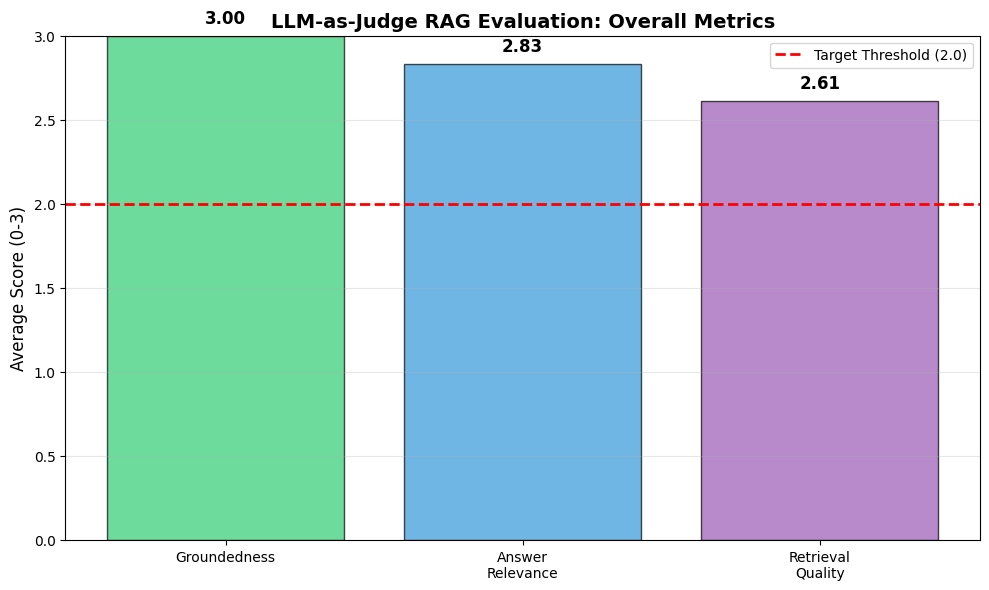

✓ Overall metrics visualization complete


In [25]:
# Create overall metrics bar chart
metrics = ["Groundedness", "Answer\nRelevance", "Retrieval\nQuality"]
scores = [avg_groundedness, avg_answer_relevance, avg_retrieval_quality]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(metrics, scores, color=['#2ecc71', '#3498db', '#9b59b6'], alpha=0.7, edgecolor='black')
ax.set_ylim(0, 3)
ax.set_ylabel("Average Score (0-3)", fontsize=12)
ax.set_title("LLM-as-Judge RAG Evaluation: Overall Metrics", fontsize=14, fontweight='bold')
ax.axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='Target Threshold (2.0)')
ax.legend(fontsize=10)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.05,
            f'{height:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Overall metrics visualization complete")

## 8.2 Per-Question Heatmap

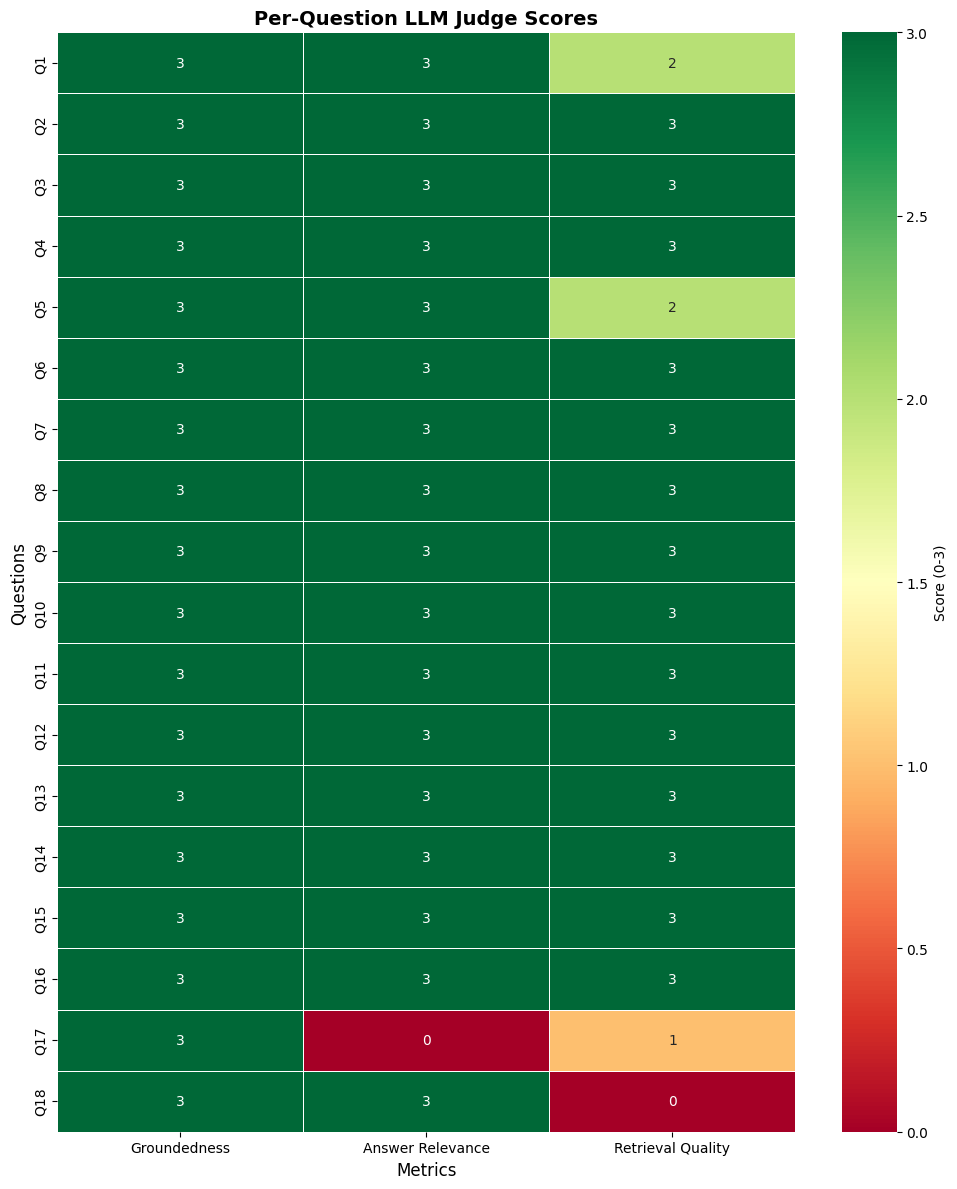

✓ Per-question heatmap complete


In [26]:
# Prepare heatmap data
heatmap_data = results_df[["groundedness_score", "answer_relevance_score", "retrieval_quality_score"]].copy()
heatmap_data.columns = ["Groundedness", "Answer Relevance", "Retrieval Quality"]
heatmap_data.index = [f"Q{i+1}" for i in range(len(heatmap_data))]

# Create heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='d',
    cmap='RdYlGn',
    vmin=0,
    vmax=3,
    cbar_kws={'label': 'Score (0-3)'},
    linewidths=0.5
)
plt.title("Per-Question LLM Judge Scores", fontsize=14, fontweight='bold')
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Questions", fontsize=12)
plt.tight_layout()
plt.show()

print("✓ Per-question heatmap complete")

## 8.3 Score Distribution

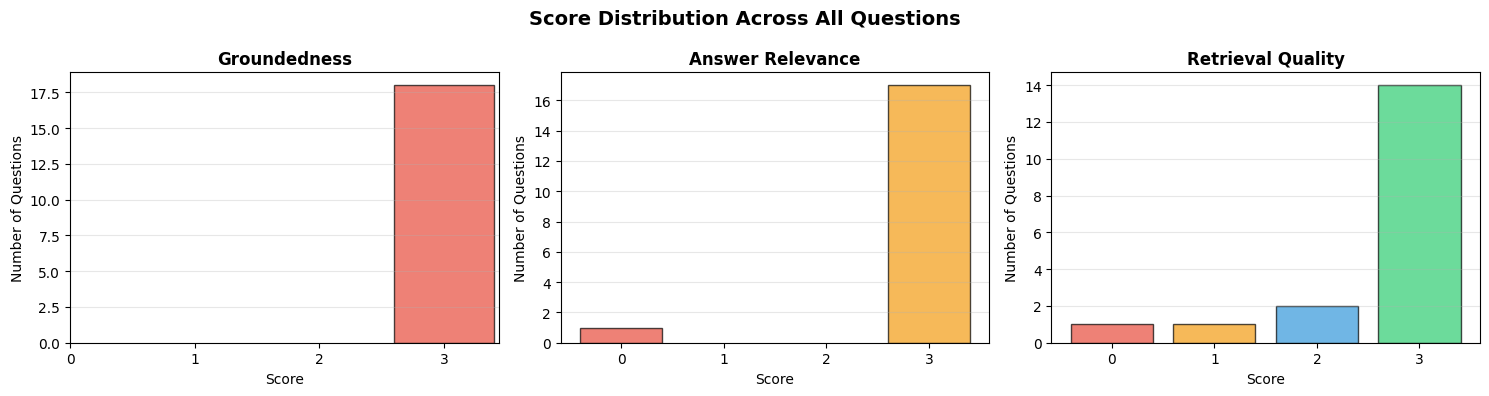

✓ Score distribution visualization complete


In [27]:
# Create score distribution plots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

metrics_list = [
    ("groundedness_score", "Groundedness"),
    ("answer_relevance_score", "Answer Relevance"),
    ("retrieval_quality_score", "Retrieval Quality")
]

for idx, (metric, title) in enumerate(metrics_list):
    counts = results_df[metric].value_counts().sort_index()
    axes[idx].bar(
        counts.index,
        counts.values,
        color=['#e74c3c', '#f39c12', '#3498db', '#2ecc71'],
        alpha=0.7,
        edgecolor='black'
    )
    axes[idx].set_xlabel("Score", fontsize=10)
    axes[idx].set_ylabel("Number of Questions", fontsize=10)
    axes[idx].set_title(title, fontsize=12, fontweight='bold')
    axes[idx].set_xticks([0, 1, 2, 3])
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle("Score Distribution Across All Questions", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Score distribution visualization complete")

## 8.4 Detailed Reasoning Analysis

Let's examine the detailed reasoning for the best and worst performing questions.

In [28]:
# Calculate total scores for each question
results_df['total_score'] = results_df[["groundedness_score", "answer_relevance_score", "retrieval_quality_score"]].sum(axis=1)

# Find best and worst performing questions
best_idx = results_df['total_score'].idxmax()
worst_idx = results_df['total_score'].idxmin()

print("\n" + "="*80)
print("📊 DETAILED REASONING ANALYSIS")
print("="*80)

# Best performing question
print(f"\n🏆 BEST PERFORMING QUESTION (Q{best_idx+1}, Total: {results_df.iloc[best_idx]['total_score']}/9)")
print("-"*80)
print(f"Question: {results_df.iloc[best_idx]['question']}")
print(f"\nGenerated Answer: {results_df.iloc[best_idx]['answer']}")
print(f"\n📌 Groundedness ({results_df.iloc[best_idx]['groundedness_score']}/3):")
print(results_df.iloc[best_idx]['groundedness_reasoning'])
print(f"\n📌 Answer Relevance ({results_df.iloc[best_idx]['answer_relevance_score']}/3):")
print(results_df.iloc[best_idx]['answer_relevance_reasoning'])
print(f"\n📌 Retrieval Quality ({results_df.iloc[best_idx]['retrieval_quality_score']}/3):")
print(results_df.iloc[best_idx]['retrieval_quality_reasoning'])

# Worst performing question
print(f"\n\n⚠️  LOWEST PERFORMING QUESTION (Q{worst_idx+1}, Total: {results_df.iloc[worst_idx]['total_score']}/9)")
print("-"*80)
print(f"Question: {results_df.iloc[worst_idx]['question']}")
print(f"\nGenerated Answer: {results_df.iloc[worst_idx]['answer']}")
print(f"\n📌 Groundedness ({results_df.iloc[worst_idx]['groundedness_score']}/3):")
print(results_df.iloc[worst_idx]['groundedness_reasoning'])
print(f"\n📌 Answer Relevance ({results_df.iloc[worst_idx]['answer_relevance_score']}/3):")
print(results_df.iloc[worst_idx]['answer_relevance_reasoning'])
print(f"\n📌 Retrieval Quality ({results_df.iloc[worst_idx]['retrieval_quality_score']}/3):")
print(results_df.iloc[worst_idx]['retrieval_quality_reasoning'])

print("\n" + "="*80)


📊 DETAILED REASONING ANALYSIS

🏆 BEST PERFORMING QUESTION (Q2, Total: 9/9)
--------------------------------------------------------------------------------
Question: What authentication protocol does CloudFlow use?

Generated Answer: CloudFlow APIs support two authentication methods: OAuth 2.0 and API Keys.

📌 Groundedness (3/3):
The answer states that CloudFlow APIs support two authentication methods: OAuth 2.0 and API Keys. This information is directly supported by Context 1, which states 'CloudFlow APIs support two authentication methods: OAuth 2.0 and API Keys.' Therefore, the answer is completely grounded in the provided context and does not contain any hallucinations.

📌 Answer Relevance (3/3):
The user asked 'What authentication protocol does CloudFlow use?' The answer 'CloudFlow APIs support two authentication methods: OAuth 2.0 and API Keys' directly answers this question by identifying the authentication protocols used by CloudFlow. The answer is concise and relevant.

📌 Ret

---

# Section 9: Cost and Performance Analysis 🚀

Let's analyze the cost and performance characteristics of LLM-as-Judge evaluation.

## 9.1 Token Usage and Cost Estimation

In [29]:
# Estimate tokens and cost
avg_prompt_tokens = 800  # Context + question + instructions
avg_completion_tokens = 400  # Reasoning for 3 metrics

total_questions = len(evaluation_dataset)
total_prompt_tokens = avg_prompt_tokens * total_questions
total_completion_tokens = avg_completion_tokens * total_questions

# GPT-4o-mini pricing (as of 2025)
prompt_cost_per_1k = 0.00015
completion_cost_per_1k = 0.0006

prompt_cost = (total_prompt_tokens / 1000) * prompt_cost_per_1k
completion_cost = (total_completion_tokens / 1000) * completion_cost_per_1k
total_cost = prompt_cost + completion_cost

print("\n" + "="*60)
print("💰 COST ANALYSIS")
print("="*60)
print(f"\nTotal Questions Evaluated: {total_questions}")
print(f"\nEstimated Token Usage:")
print(f"  • Prompt Tokens: ~{total_prompt_tokens:,}")
print(f"  • Completion Tokens: ~{total_completion_tokens:,}")
print(f"  • Total Tokens: ~{total_prompt_tokens + total_completion_tokens:,}")
print(f"\nEstimated Cost (GPT-4o-mini):")
print(f"  • Prompt Cost: ${prompt_cost:.4f}")
print(f"  • Completion Cost: ${completion_cost:.4f}")
print(f"  • Total Cost: ${total_cost:.4f}")
print(f"  • Cost per Question: ${total_cost/total_questions:.4f}")
print("\n" + "="*60)


💰 COST ANALYSIS

Total Questions Evaluated: 18

Estimated Token Usage:
  • Prompt Tokens: ~14,400
  • Completion Tokens: ~7,200
  • Total Tokens: ~21,600

Estimated Cost (GPT-4o-mini):
  • Prompt Cost: $0.0022
  • Completion Cost: $0.0043
  • Total Cost: $0.0065
  • Cost per Question: $0.0004



## 9.2 LLM-as-Judge vs Ragas Comparison

Here's a comprehensive comparison of both evaluation approaches.

In [30]:
# Create comparison table
comparison_data = {
    "Aspect": [
        "Evaluation Time",
        "Cost per Run",
        "Flexibility",
        "Reasoning Transparency",
        "Consistency",
        "Setup Complexity",
        "Metrics Available",
        "Best Use Case"
    ],
    "LLM-as-Judge": [
        "5-8 minutes",
        "$0.08-0.12",
        "High (custom metrics)",
        "Excellent (detailed)",
        "Good (with temp=0)",
        "Low (just prompts)",
        "3 core metrics",
        "Custom evaluation, detailed feedback"
    ],
    "Ragas Framework": [
        "7-12 minutes",
        "$0.05-0.08",
        "Medium (preset metrics)",
        "Limited (scores only)",
        "Excellent (standardized)",
        "Medium (metric config)",
        "6+ metrics",
        "Standardized benchmarks, large-scale"
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("⚖️  LLM-AS-JUDGE VS RAGAS FRAMEWORK")
print("="*80)
print()
print(comparison_df.to_string(index=False))
print("\n" + "="*80)


⚖️  LLM-AS-JUDGE VS RAGAS FRAMEWORK

                Aspect                         LLM-as-Judge                      Ragas Framework
       Evaluation Time                          5-8 minutes                         7-12 minutes
          Cost per Run                           $0.08-0.12                           $0.05-0.08
           Flexibility                High (custom metrics)              Medium (preset metrics)
Reasoning Transparency                 Excellent (detailed)                Limited (scores only)
           Consistency                   Good (with temp=0)             Excellent (standardized)
      Setup Complexity                   Low (just prompts)               Medium (metric config)
     Metrics Available                       3 core metrics                           6+ metrics
         Best Use Case Custom evaluation, detailed feedback Standardized benchmarks, large-scale



## 9.3 Best Practices and Recommendations

In [31]:
print("\n" + "="*80)
print("🎯 BEST PRACTICES FOR LLM-AS-JUDGE")
print("="*80)
print("""
1. **Judge Prompt Engineering**
   ✓ Be explicit about scoring criteria
   ✓ Provide examples of each score level
   ✓ Use consistent terminology
   ✓ Request step-by-step reasoning

2. **Consistency Strategies**
   ✓ Always use temperature=0
   ✓ Use structured outputs (Pydantic)
   ✓ Include rubric in system prompt
   ✓ Test judge calibration with known examples

3. **Cost Optimization**
   ✓ Batch evaluations when possible
   ✓ Use concise context formatting
   ✓ Consider cheaper models for simpler metrics
   ✓ Cache repeated evaluations

4. **Quality Assurance**
   ✓ Validate judge on ground truth dataset
   ✓ Compare against human evaluations
   ✓ Check for systematic biases
   ✓ Monitor score distributions

5. **When to Use LLM-as-Judge**
   ✓ Need custom evaluation metrics
   ✓ Want detailed reasoning/explanations
   ✓ Evaluating subjective qualities
   ✓ Small to medium evaluation sets (<1000 questions)
   ✓ Need to understand *why* something scored a certain way

6. **When to Use Ragas Instead**
   ✓ Need standardized benchmarks
   ✓ Large-scale evaluations (1000+ questions)
   ✓ Cost is primary constraint
   ✓ Industry-standard metrics sufficient
   ✓ Comparing against published baselines
""")
print("="*80)


🎯 BEST PRACTICES FOR LLM-AS-JUDGE

1. **Judge Prompt Engineering**
   ✓ Be explicit about scoring criteria
   ✓ Provide examples of each score level
   ✓ Use consistent terminology
   ✓ Request step-by-step reasoning

2. **Consistency Strategies**
   ✓ Always use temperature=0
   ✓ Use structured outputs (Pydantic)
   ✓ Include rubric in system prompt
   ✓ Test judge calibration with known examples

3. **Cost Optimization**
   ✓ Batch evaluations when possible
   ✓ Use concise context formatting
   ✓ Consider cheaper models for simpler metrics
   ✓ Cache repeated evaluations

4. **Quality Assurance**
   ✓ Validate judge on ground truth dataset
   ✓ Compare against human evaluations
   ✓ Check for systematic biases
   ✓ Monitor score distributions

5. **When to Use LLM-as-Judge**
   ✓ Need custom evaluation metrics
   ✓ Want detailed reasoning/explanations
   ✓ Evaluating subjective qualities
   ✓ Small to medium evaluation sets (<1000 questions)
   ✓ Need to understand *why* something

---

# 🎉 Conclusion

Congratulations! You've successfully:

✅ Built a complete RAG pipeline with CloudFlow documentation
✅ Implemented LLM-as-Judge evaluation with structured outputs
✅ Evaluated 18 questions across 3 core metrics
✅ Analyzed results with detailed reasoning and visualizations
✅ Understood cost and performance trade-offs

## Key Takeaways

1. **LLM-as-Judge provides transparency**: Unlike black-box metrics, you get detailed reasoning for every score
2. **Flexibility is powerful**: You can define custom metrics for your specific use case
3. **Cost-effectiveness**: At ~$0.10 per run, it's affordable for development and testing
4. **Complementary approach**: Use alongside Ragas for best of both worlds

## Next Steps

- **Experiment with different judge prompts** to see how they affect scoring
- **Compare results with Ragas evaluation** (Notebook 10)
- **Test on your own RAG system** with custom documents and questions
- **Validate judge scores** against your own human evaluations
- **Explore other metrics** like correctness (with ground truth) or tone/style

## Resources

- [LangChain Documentation](https://python.langchain.com/)
- [OpenAI Structured Outputs](https://platform.openai.com/docs/guides/structured-outputs)
- [Pydantic Documentation](https://docs.pydantic.dev/)
- [Ragas Framework](https://docs.ragas.io/)

---

**Happy Evaluating! 🚀**